In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D

import time
import copy
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import os
import imageio
import pydicom as dicom
import pandas as pd
import sys

import SimpleITK
from scipy import ndimage as ndi
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import disk, dilation, binary_erosion, binary_closing
from skimage.filters import roberts, sobel
import cv2
from KEM_EXPE import *
from experiment_auxiliary import *
import re

sys.path.append('../')
sys.path.append('../Models/')

from utils import *
from GMM import *
from Kmeans import *
%matplotlib inline

In [2]:
depth = 99  # the depth th slice will be shown

path = '/database/datasets/Classics/LIDCdata/'  # LIDC dataset
patient_folders = os.listdir(path)
print(len(patient_folders))

# np.random.seed(609)
# index_list = np.random.randint(low=0, high=len(patient_folders), size=(3))
# index_list

158


In [3]:
index_list = [2, 19, 47]

In [4]:
for index in index_list:
    print(get_patient_folder(path, index))

/database/datasets/Classics/LIDCdata/LIDC-IDRI-0405/01-01-2000-NA-NA-51249/30078.000000-NA-51914/
/database/datasets/Classics/LIDCdata/LIDC-IDRI-0811/01-01-2000-1-NA-15517/30007.000000-NA-84692/
/database/datasets/Classics/LIDCdata/LIDC-IDRI-0875/01-01-2000-NA-NA-92135/30034.000000-NA-78531/


In [5]:
index = index_list[0]

In [6]:
## raw CT data folder
original_folder = get_patient_folder(path, index)

name = copy.copy(original_folder)
name = re.findall('LIDC-IDRI-[0-9]*', name)[0]

patient_folder = get_patient_folder(path, index)  # the patient's folder
# read in experiment data
experiment_data, slope, intercept = load_experiment_data_lidc(patient_folder)
print(experiment_data.shape)

(260, 512, 512)


In [7]:
slope, intercept

(1.0, -1000.0)

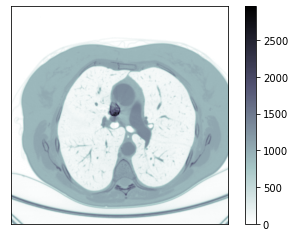

In [8]:
# show_slice(experiment_data[depth], None, False)
show_slice(experiment_data[depth], None, True)

# Lung Concentration

In [9]:
lung_threshold = -200

t1 = time.time()
concentrated_data = lung_concentration(experiment_data, lung_threshold, slope, intercept)
t2 = time.time()
print(f"lung concentration: {t2 - t1:.6f}")

lung concentration: 22.752726


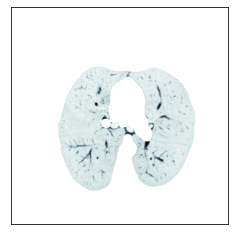

In [10]:
show_slice(concentrated_data[depth], None, False)
# show_slice(concentrated_data[depth], None, True)

In [11]:
# output_folder = f"./[ConcetratedLung]-{name}/" 

# tmp = transfer_pi_to_dicom_raw(concentrated_data, original_folder, output_folder, truncate_threshold=None)

In [12]:
# plt.imshow(tmp[depth])

In [13]:
# rescale the data
CT_min = concentrated_data.min()
CT_max = concentrated_data.max()
concentrated_data = (concentrated_data - CT_min) / (CT_max - CT_min)

In [14]:
CT_min, CT_max

(0.0, 3170.0)

In [15]:
shape = concentrated_data.shape
experiment_data = tf.cast(tf.convert_to_tensor(concentrated_data), tf.float32)
experiment_data = tf.reshape(experiment_data, (1,) + experiment_data.shape + (1,))

2024-01-23 12:28:00.012799: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 12:28:00.600692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:35:00.0, compute capability: 8.0


In [16]:
np.random.seed(0)
tf.random.set_seed(0)

In [17]:
Ch = 0.2217
sample_size = shape[0] * shape[1] * shape[2]
bandwidth_base = sample_size**(-1/7)
optimal_bandwidth = Ch * bandwidth_base
kernel_shape = (3, 3, 3)
# optimal_bandwidth = 10 / 512

In [18]:
# use all the data
training_ratio = 1
position_mask = np.random.binomial(n=1, p=training_ratio, size=experiment_data.shape)
position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
training_data = position_mask * experiment_data

# GMM

In [19]:
gmm_pre = GMM(K=3, 
                shape=shape, 
                training_data=training_data, 
                position_mask=position_mask, 
                kmeans_sample_ratio=1/100/training_ratio,
                testing_data=None)

From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.009995 data for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 1.928 seconds
	centers: [2.3470032e-01 5.2751716e-02 8.2619437e-05]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 1, 1, 1, 1)
	mu_estimate: (3, 1, 1, 1, 1)
	sigma_estimate: (3, 1, 1, 1, 1)


In [20]:
gmm_pre.gmm_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)

From function(gmm_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.068619
From function(gmm_algorithm): E step success.
pi_estimator: [0.00763363 0.3997685  0.59327674]

mu_estimate: [2.3470032e-01 5.2751716e-02 8.2619437e-05]
sigma_estimator: [0.08429305 0.02539451 0.01443507]
	 Current pi difference: 0.0593548
	 Current mu difference: 0.000601281
	 Current sigma difference: 0.00101544
From function(gmm_algorithm): M step success.
From function(gmm_algorithm): difference: 0.0609715.
---This iteration step costs 0.1218 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.0143348
From function(gmm_algorithm): E step success.
pi_estimator: [0.01398713 0.34224823 0.6426033 ]

mu_estimate: [0.22233132 0.01233998 0.0042948 ]
sigma_estimator: [0.08393744 0.02599178 0.00613832]
	 Current pi difference: 0.00192735
	 Cur

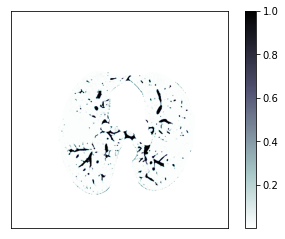

In [21]:
gmm_pik_estimate = gmm_pre.pik_estimate
k = 0
show_slice(gmm_pik_estimate[k, depth])

In [22]:
gmm_result = tf.squeeze(gmm_pre.pik_estimate)[0]

## Generate synthetic responses by GMM method

In [28]:
one = tf.ones((3, 260, 512, 512, 1))
mu = tf.squeeze(gmm_pre.mu_estimate * one)
sigma = tf.squeeze(gmm_pre.sigma_estimate * one)
pi = tf.squeeze(gmm_pre.pik_estimate)

In [30]:
pi_max = tf.reduce_max(pi, axis=0)
pi_new = tf.cast(pi == pi_max, tf.float32)
pi_new.shape

TensorShape([3, 260, 512, 512])

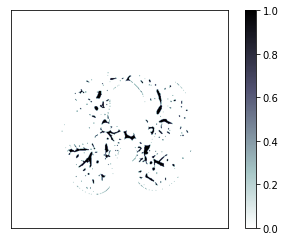

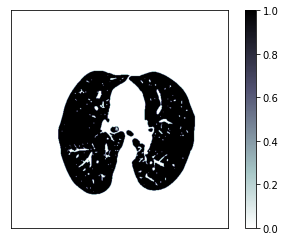

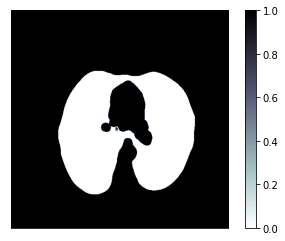

In [31]:
for k in range(3):
    show_slice(pi_new[k, depth])

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D
import time
import copy
from sklearn.cluster import KMeans
import pandas as pd
import gc
from sklearn.linear_model import LinearRegression
import math
import tensorflow as tf
from multiprocessing import Process, Manager
import datetime
import sys
import csv
import os
from tensorflow.keras.utils import to_categorical

sys.path.append('../')
sys.path.append('../Models/')
sys.path.append('../KEM_simulation/')
from utils import *
from GMM import *
from Kmeans import *
from data_generate import *  # 参数生成文件
from KEM_SIMU import *  # KEM 类

%matplotlib inline

################ k = 0 ################
[0] tmp_data.max: 0.6472
[0] tmp_data.mean: 0.1595


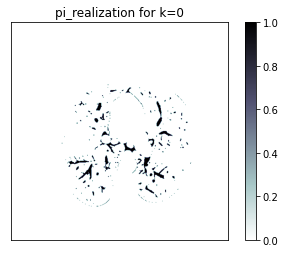

################ k = 1 ################
[1] tmp_data.max: 0.133
[1] tmp_data.mean: 0.04867


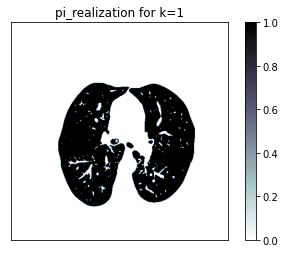

################ k = 2 ################
[2] tmp_data.max: 5.634e-20
[2] tmp_data.mean: 1.565e-24


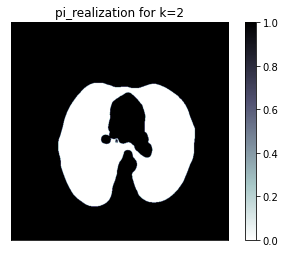

from function(generate_simulate_data_new_version): simulate_data.max=0.5808


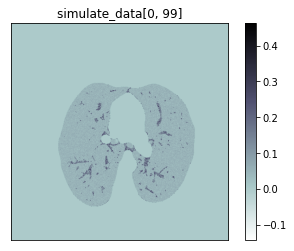

In [34]:
simulate_data, pi_realization = generate_simulate_data_new_version(pi_new, mu, sigma, seed=0, IsShow=True)

In [35]:
# simulate_data = gmm_pre.pik_estimate[0]
# simulate_data = tf.reshape(simulate_data, (1,)+simulate_data.shape)
# simulate_data.shape

In [36]:
simu_min = tf.reduce_min(simulate_data)
simu_max = tf.reduce_max(simulate_data)

simulate_data = (simulate_data - simu_min) / (simu_max - simu_min)

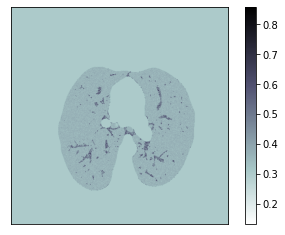

In [37]:
show_slice(simulate_data[0, depth])

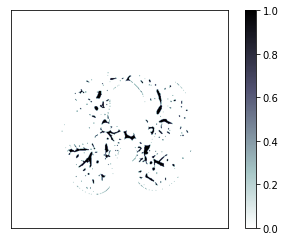

In [43]:
show_slice(pi_realization[0, depth])

In [44]:
output_folder = f"./3D Reconstruction/[(GMM_GT)]-{name}/" 

tmp = transfer_pi_to_dicom(pi_realization[0].numpy(), original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====recreate the folder at ./3D Reconstruction/[(GMM_GT)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[(GMM_GT)]-LIDC-IDRI-0405/====


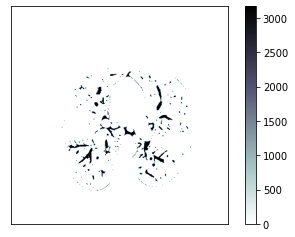

In [45]:
show_slice(tmp[depth])

In [46]:
np.random.seed(0)
tf.random.set_seed(0)

training_ratio = 1  # ratio of the voxel positions are used for training
# training_ratio = 1  # ratio of the voxel positions are used for training
# generate a mask, if =1 then are maintained as training data
position_mask = np.random.binomial(n=1, p=training_ratio, size=simulate_data.shape)
position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
training_data = position_mask * simulate_data
# if =0 then are maintained as training data
testing_data = (1 - position_mask) * simulate_data

In [47]:
position_mask.shape

TensorShape([1, 260, 512, 512, 1])

In [48]:
single_class = pi_realization[1] * 1 + pi_realization[2] * 2
true_test_class = single_class[tf.squeeze(position_mask) < 0.5]

# $k$-means

In [49]:
kmeans_model = Kmeans(K=3,
                      shape=shape, 
                      training_data=training_data, 
                      position_mask=position_mask, 
                      kmeans_sample_ratio=1/100/training_ratio,
                      testing_data=None)

From function(__init__): Randomly pick 0.009995 data for kmeans.


In [50]:
kmeans_model.kmeans_algorithm(max_steps=50)

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1305: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


In [51]:
kmeans_labels = kmeans_model.predict_all_class()

(1, 260, 512, 512, 1)


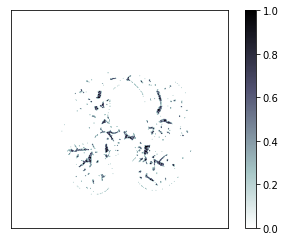

In [52]:
kmeans_class_results = tf.cast(kmeans_labels == 0, tf.float32)
show_slice(kmeans_class_results[0, depth])

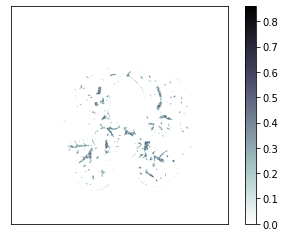

In [53]:
kmeans_results = training_data * tf.cast(kmeans_labels == 0, tf.float32) # 原来的代码
show_slice(kmeans_results[0, depth])

In [54]:
kmeans_result = kmeans_results[0].numpy()

In [57]:
output_folder = f"./3D Reconstruction/[kmeans_CTvalue(GMM)]-{name}/" #({datetime.date.today().strftime('%y%m%d')})

tmp = transfer_pi_to_dicom(kmeans_result, original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====create a new folder at ./3D Reconstruction/[kmeans_CTvalue(GMM)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[kmeans_CTvalue(GMM)]-LIDC-IDRI-0405/====


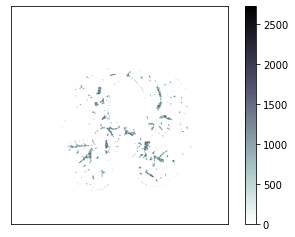

In [58]:
show_slice(tmp[depth])

# GMM

In [59]:
gmm_model = GMM(K=3, 
                shape=shape, 
                training_data=training_data, 
                position_mask=position_mask, 
                kmeans_sample_ratio=1/100/training_ratio,
                testing_data=None)

From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.009995 data for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 1.599 seconds
	centers: [0.5567754  0.36473608 0.30260426]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 1, 1, 1, 1)
	mu_estimate: (3, 1, 1, 1, 1)
	sigma_estimate: (3, 1, 1, 1, 1)


In [60]:
gmm_model.gmm_algorithm(max_steps=50, epsilon=1e-4, smooth_parameter=1e-20)

From function(gmm_algorithm): Receive max_steps: 50.
########################## STEP 0 ##########################
	 Current pik difference: 0.0794529
From function(gmm_algorithm): E step success.
pi_estimator: [0.00890971 0.3608797  0.6309254 ]

mu_estimate: [0.5567754  0.36473608 0.30260426]
sigma_estimator: [0.07259089 0.02983949 0.01521203]
	 Current pi difference: 0.0648568
	 Current mu difference: 0.00070292
	 Current sigma difference: 0.000708999
From function(gmm_algorithm): M step success.
From function(gmm_algorithm): difference: 0.0662688.
---This iteration step costs 0.1177 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.0145107
From function(gmm_algorithm): E step success.
pi_estimator: [0.01115972 0.3002147  0.6887165 ]

mu_estimate: [0.5534003  0.31905004 0.30579084]
sigma_estimator: [0.08073787 0.03232555 0.00473365]
	 Current pi difference: 0.0023417
	 Current mu difference: 0.000213851
	 Current sigma difference: 6.0

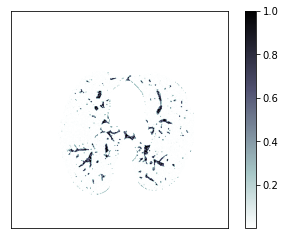

In [61]:
gmm_pik_estimate = gmm_model.pik_estimate
k = 0
show_slice(gmm_pik_estimate[k, depth])

In [63]:
gmm_result = tf.squeeze(gmm_model.pik_estimate)[0]

In [64]:
output_folder = f"./3D Reconstruction/[GMM_pik(GMM)]-{name}/" #({datetime.date.today().strftime('%y%m%d')})

tmp = transfer_pi_to_dicom(gmm_result.numpy(), original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====create a new folder at ./3D Reconstruction/[GMM_pik(GMM)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[GMM_pik(GMM)]-LIDC-IDRI-0405/====


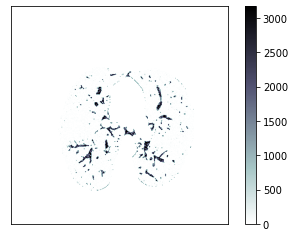

In [66]:
show_slice(tmp[depth])

# KEM Algorithm

In [67]:
np.random.seed(0)
tf.random.set_seed(0)

In [68]:
Ch = 0.2217
sample_size = shape[0] * shape[1] * shape[2]
bandwidth_base = sample_size**(-1/7)
optimal_bandwidth = Ch * bandwidth_base
kernel_shape = (5, 5, 5)
# optimal_bandwidth = 10 / 512

In [69]:
t1 = time.time()
kem_cv = KEM_EXPE(K=3, shape=shape, 
                  training_data=training_data, 
                  position_mask=position_mask, 
                  kernel_shape=kernel_shape, 
                  bandwidth=optimal_bandwidth, 
                  kmeans_sample_ratio=1/100/training_ratio,
                  testing_data=None)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(KEM_SIMU.__init__): training_data.shape: (1, 260, 512, 512, 1)
From function(__init__): Initialize mu via kmeans(with K=3)
Randomly pick 0.009993479802058293 positions for kmeans.
[0.5549414739384435, 0.36468680832390193, 0.3026067192818819]
From function(kmeans_initialization): rearanged centers: [0.5549414739384435, 0.36468680832390193, 0.3026067192818819]
From function(__init__): KMeans(with K=3) success, with time: 1.591 seconds
	centers: [0.5549415  0.36468682 0.30260673]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 260, 512, 512, 1)
	mu_estimate: (3, 260, 512, 512, 1)
	sigma_estimate: (3, 260, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (5, 5, 5, 1, 1)
 1.611529


In [70]:
t1 = time.time()
kem_cv.kem_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(kem_algorithm): Receive max_steps: 20.


2024-01-23 12:32:42.945658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


########################## STEP 0 ##########################
	 Current pik difference: 0.0481038
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0462683
	 Current mu difference: 0.0203685
	 Current sigma difference: 0.0103311
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.0769679.
---This iteration step costs 6.876 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.116086
From function(kem_algorithm): E step success.
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 0.114427
	 Current mu difference: 4.50916e-05
	 Current sigma difference: nan
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: nan.
---This iteration step costs 2.081 seconds.---
 14.621173


- posterior probability:

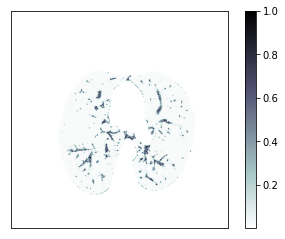

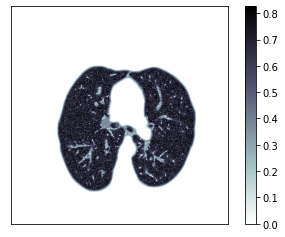

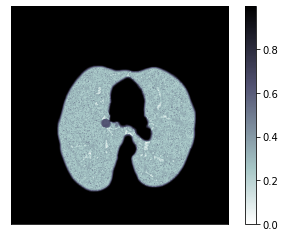

In [71]:
kem_pik_estimate = kem_cv.pik_estimate
for k in range(3):
    show_slice(kem_pik_estimate[k, depth])

In [73]:
kem_result = tf.squeeze(kem_pik_estimate)[0]

In [74]:
output_folder = f"./3D Reconstruction/[KEM_pik(GMM)]-{name}/" 

tmp = transfer_pi_to_dicom(kem_result.numpy(), original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====create a new folder at ./3D Reconstruction/[KEM_pik(GMM)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[KEM_pik(GMM)]-LIDC-IDRI-0405/====


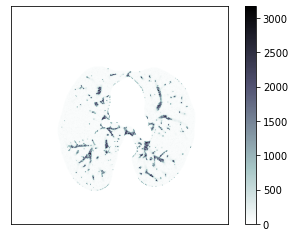

In [75]:
show_slice(tmp[depth])

In [20]:
# # Step 1. binary image
# aslice = copy.copy(img[depth])
# binary = aslice <= lung_threshold_m    # 二值化图像
# show_slice(binary, title="Step 1") # 1

# # Step 2. clear border
# cleared = clear_border(binary)   # 清除图像边界的小块区域
# show_slice(cleared, title="Step 2") # 2

# # Step 3. 分割图像
# label_image = label(cleared)     # 分割图像
# show_slice(label_image, title="Step 3")

# # Step 4. pick out 2 largest connected-area
# regions = regionprops(label_image)
# areas = [r.area for r in regions]  # 保留2个最大的联通区域
# areas.sort()
# if len(areas) > 2:
#     for region in regions:
#         if region.area < areas[-2]:
#             for coordinates in region.coords:
#                 label_image[coordinates[0], coordinates[1]] = 0
# binary = label_image > 0
# show_slice(binary, title="Step 4")

# # Step 5: 图像腐蚀操作,将结节与血管剥离
# selem = disk(2)                         # Step 5: 图像腐蚀操作,将结节与血管剥离
# binary = binary_erosion(binary, selem)
# show_slice(binary, title="Step 5")

# # Step 6: 图像闭环操作,保留贴近肺壁的结节
# selem = disk(10)                        
# binary = binary_closing(binary, selem)
# show_slice(binary, title="Step 6")

# # # Step 7: 进一步将肺区残余小孔区域填充
# # edges = roberts(binary)
# # binary = ndi.binary_fill_holes(edges)
# # show_slice(binary)

# get_high_vals = binary == 0             # Step 8: 将二值化图像叠加到输入图像上
# aslice[get_high_vals] = 0
# plt.imshow(aslice)
# plt.axis('off')
# plt.show()